# Implementación de pipelines de modelos transformers pre-entrenados

Aplicar modelos preentrenados basados en Transformers mediante el uso de la función pipeline() de la librería 🤗 [Hugging Face](https://huggingface.co/docs/transformers/index), para realizar análisis de sentimientos sobre tweets en español tomados del corpus del [TASS 2020](https://ucom.instructure.com/courses/1763/files/210303?wrap=1).

El conjunto de datos en español del TASS 2020 pertenece a una competición de análisis de sentimientos en Twitter, contiente tweets en español con anotaciones de sentimiento (positivo, negativo, neutral, etc.).
<hr />

In [1]:
!pip install datasets
!pip install evaluate
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "L

In [2]:
# Imports
import pandas as pd
from datasets import load_dataset, Dataset, Features, ClassLabel, Sequence, Value, DatasetDict
#
import seaborn as sns
import matplotlib.pyplot as plt

**Parte 1: Preprocesamiento**

1. Lee el archivo del conjunto de datos.

In [3]:
# Dev
url_dev = "https://corpusdata.blob.core.windows.net/tass-2020/dev.tsv"

df_dev = pd.read_csv(url_dev, delimiter="\t")
df_dev.head(10)

,id,texto,etiqueta,pais
0,773238965709176832,@chefidiaz no seas muy dura,N,es
1,770702799470489601,@lantoli podemos usar el término.equipo pepino,NEU,es
2,770238084764041217,Como destrozaba el puto movil ahora mismo,N,es
3,770222346829520896,@YG__GF me ofrecería pero gerald es demasiado ...,NEU,es
4,770560227531948032,@omixam no creo que hayan diseñado una tipo pr...,N,es
5,771092070572449796,@Jorge_Ruiz14 yo no tengo tiempo para esas cos...,N,es
6,770059333489025024,"@Hanita_chan nfin, no puede ser peor que un mi...",N,es
7,770550748107202560,@CondeDuqueMAD ¿mañana sábado 31? En que día v...,NEU,es
8,771092421866389508,@piscolabisaereo @HistoriaNG @SPosteguillo las...,P,es
9,771094192508600320,@_MissChaotic_ ves ese brillo? es un coso que ...,N,es


In [4]:
# Train
url_train = "https://corpusdata.blob.core.windows.net/tass-2020/train.tsv"

df_train = pd.read_csv(url_train, delimiter="\t")
df_train.head(10)

,id,texto,etiqueta,pais
0,768512386269638656,@morbosaborealis jajajaja... eso es verdad... ...,N,es
1,768529956162924544,@Adriansoler espero y deseo que el interior te...,NEU,es
2,768557093955698688,"comprendo que te molen mis tattoos, pero no te...",NEU,es
3,770616744192929792,"Mi última partida jugada, con Sona support. La...",P,es
4,769959690092642304,Tranquilos que con el.dinero de Camacho seguro...,P,es
5,770590136828559360,"@daniacal aún no, pero si estará jugable en el...",P,es
6,770434744748236800,@ragnomuelle Yo a veces hecho de menos mi pelo...,N,es
7,770787189319925760,A mí nunca me podrán hacer una broma porque no...,NEU,es
8,771339035445002240,#feliz septiembre..es bonito retarse..es incre...,P,es
9,768577963885522944,Este año el Madrid hará triplete y si lo hace ...,P,es


In [5]:
# Test
url_test = "https://corpusdata.blob.core.windows.net/tass-2020/test.tsv"

df_test = pd.read_csv(url_test, delimiter="\t")
df_test.head(10)

,id,texto,pais,etiqueta
0,770809220291760128,Quiero que alguien me diga cosas bonitas,ES,N
1,772825676793589760,@RavlRVara ¡Síguenos porfa! Tenemos que decirt...,ES,NEU
2,772508582923337729,@Charlywayty @Karim0931 cualquiera diría que e...,ES,NEU
3,790657169876193281,"a to esto, el tio de ono no ha venio",ES,N
4,770967255773507584,@IKEASpain es el mismo así que tomo nota de to...,ES,P
5,770772755637764096,"q en horas estemos en septiembre, perdona?????...",ES,N
6,771019034498301952,@julioinsadji Estás muy calladito por aquí jul...,ES,N
7,769930322721013760,@JPelirrojo me encantan los VAPES gracias por ...,ES,P
8,771018908149157888,@HuGo17__ @BayonTHE1 Vamos con PAM que preferi...,ES,P
9,770027650610003968,@zKnowcks7 la culpa es de la gente que juega s...,ES,N


* (Opcional) Haz una limpieza ligera del texto (eliminación de URLs, menciones, etc.)

In [ ]:
import re

def limpiar_texto(texto):
    texto = re.sub(r"@\w+", "", texto)           # Quitar menciones
    texto = re.sub(r"http\S+", "", texto)        # Quitar URLs que empiecen con http
    texto = re.sub(r"www\.\S+", "", texto)       # Quitar URLs que empiecen con www
    texto = re.sub(r"\s+", " ", texto).strip()   # Eliminar espacios extra
    return texto

# df_concatenado = pd.concat([df_test, df_train, df_dev], ignore_index=True)
df_concatenado = pd.concat([df_test, df_train], ignore_index=True)
df_concatenado["texto_limpio"] = df_concatenado["texto"].apply(limpiar_texto)

In [ ]:
df_concatenado[["texto", "texto_limpio"]].head(10)

,texto,texto_limpio
0,Quiero que alguien me diga cosas bonitas,Quiero que alguien me diga cosas bonitas
1,@RavlRVara ¡Síguenos porfa! Tenemos que decirt...,¡Síguenos porfa! Tenemos que decirte una cosa
2,@Charlywayty @Karim0931 cualquiera diría que e...,cualquiera diría que estamos deseando pasar frío
3,"a to esto, el tio de ono no ha venio","a to esto, el tio de ono no ha venio"
4,@IKEASpain es el mismo así que tomo nota de to...,es el mismo así que tomo nota de todo #gracias
5,"q en horas estemos en septiembre, perdona?????...","q en horas estemos en septiembre, perdona?????..."
6,@julioinsadji Estás muy calladito por aquí jul...,Estás muy calladito por aquí julio... q n pued...
7,@JPelirrojo me encantan los VAPES gracias por ...,me encantan los VAPES gracias por estar ahí to...
8,@HuGo17__ @BayonTHE1 Vamos con PAM que preferi...,"Vamos con PAM que preferimos entrenar vs DDH, ..."
9,@zKnowcks7 la culpa es de la gente que juega s...,la culpa es de la gente que juega segunda no t...


2. Extrae los tweets y sus etiquetas de sentimiento y guardalos en una estructura [Dataset](https://huggingface.co/docs/datasets/index).

In [ ]:
# Hacer drop de las columnas irrelevantes para mantener únicamente
# los tweets con sus etiquetas de sentimiento
df_concatenado = df_concatenado.drop(columns=["id", "pais", "texto"])

# Mapear las etiquetas de texto a valores numéricos
# Negativo: 0 | Neutral: 1 | Positivo: 2
mapeo_etiquetas = {"N": 0, "NEU": 1, "P": 2}
df_concatenado["etiqueta"] = df_concatenado["etiqueta"].map(mapeo_etiquetas)

In [ ]:
df_concatenado.head()

,etiqueta,texto_limpio
0,0,Quiero que alguien me diga cosas bonitas
1,1,¡Síguenos porfa! Tenemos que decirte una cosa
2,1,cualquiera diría que estamos deseando pasar frío
3,0,"a to esto, el tio de ono no ha venio"
4,2,es el mismo así que tomo nota de todo #gracias


In [ ]:


# Definir la estructura del dataset de Huggingface, la etiqueta es de tipo ClassLabel
# y la variable names contiene el nombre de las etiquetas en el mismo orden que el mapeo
features = Features({
    "texto_limpio": Value("string"),
    "etiqueta": ClassLabel(num_classes=3, names=["N", "NEU", "P"])
})

In [ ]:
# Transformar de dataframe a dataset
dataset = Dataset.from_pandas(
    df_concatenado,
    features=features
)

dataset = dataset.rename_column("texto_limpio", "text")
dataset = dataset.rename_column("etiqueta", "label")

In [ ]:
# Crear el diccionario de datasets
datasetTass = DatasetDict({"dataset": dataset})
datasetTass

DatasetDict({
    dataset: Dataset({
        features: ['text', 'label'],
        num_rows: 12066
    })
})

<hr/>

**Parte 2: Análisis con modelos preentrenados**

1. Usa un modelo en español compatible con análisis de sentimiento desde Hugging Face, por ejemplo:

  - [pysentimiento/robertuito-sentiment-analysis](https://huggingface.co/pysentimiento/robertuito-sentiment-analysis)

  - [finiteautomata/beto-sentiment-analysis](https://huggingface.co/finiteautomata/beto-sentiment-analysis)

    **Ejemplo de código:**

    `from transformers import pipeline classifier = pipeline("text-classification", model="pysentimiento/robertuito-sentiment-analysis", top_k=None)`

In [ ]:
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset

In [ ]:
# Instanciamos el pipeline de clasificación de texto
# El modelo de clasificación de texto es el modelo robertuito
# de la librería pysentimiento
pipe = pipeline(task="text-classification", model="pysentimiento/robertuito-sentiment-analysis")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/925 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

Device set to use cpu


2. Aplica el modelo a los textos del corpus para predecir el sentimiento.

In [ ]:
# Realizamos la predicción en el dataset y almacenamos el resultado
resultado = pipe(KeyDataset(datasetTass["dataset"], "text"), batch_size=8, truncation="only_first")

In [ ]:
# Iteramos sobre el resultado y lo almacenamos en un dataframe
# para mostrarlo de una forma más amigable y calcular métricas de evaluación
df_resultados = pd.DataFrame([
    {
        "Texto": entrada["text"],
        "Etiqueta": entrada["label"],
        "Prediccion": label["label"],
        "Confianza": label["score"]
    }
    for entrada, label in zip(datasetTass["dataset"], resultado)
])

In [ ]:
df_resultados.head(10)

,Texto,Etiqueta,Prediccion,Confianza
0,Quiero que alguien me diga cosas bonitas,0,POS,0.401291
1,¡Síguenos porfa! Tenemos que decirte una cosa,1,NEU,0.623305
2,cualquiera diría que estamos deseando pasar frío,1,NEG,0.823532
3,"a to esto, el tio de ono no ha venio",0,NEG,0.687506
4,es el mismo así que tomo nota de todo #gracias,2,NEU,0.506097
5,"q en horas estemos en septiembre, perdona?????...",0,NEG,0.721704
6,Estás muy calladito por aquí julio... q n pued...,0,NEG,0.923936
7,me encantan los VAPES gracias por estar ahí to...,2,POS,0.972588
8,"Vamos con PAM que preferimos entrenar vs DDH, ...",2,POS,0.835990
9,la culpa es de la gente que juega segunda no t...,0,NEG,0.941849


3. Compara los resultados del modelo con las etiquetas reales.

In [ ]:
# Calculamos las métricas de evaluación usando la librería sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
mapeo_labels = {"NEG" :0, "NEU": 1, "POS": 2}

# Convertimos las etiquetas y predicciones a formato numérico usando el mapeo definido
# en el diccionario mapeo_labels
y_true = df_resultados["Etiqueta"].astype(int)
y_pred = df_resultados["Prediccion"].map(mapeo_labels).astype(int)

4. Calcula métricas como accuracy, F1-score, precision, recall.

In [ ]:
# Calculamos el reporte de clasificación
print(classification_report(y_true, y_pred, target_names=mapeo_labels.keys()))

# Calculamos la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print(cm)

              precision    recall  f1-score   support

         NEG       0.81      0.85      0.83      4824
         NEU       0.65      0.62      0.64      3489
         POS       0.82      0.81      0.81      3753

    accuracy                           0.77     12066
   macro avg       0.76      0.76      0.76     12066
weighted avg       0.77      0.77      0.77     12066

[[4082  594  148]
 [ 794 2169  526]
 [ 165  560 3028]]


- El modelo es relativamente bueno con las clases NEG y POS, pero no tanto con la clase NEU, que también es donde tiene la menor cantidad de ejemplos.

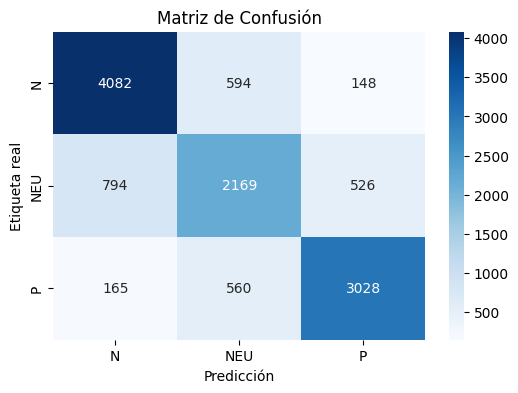

In [ ]:
etiquetas = ["N", "NEU", "P"]

# Dibujar el heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=etiquetas, yticklabels=etiquetas)

# Agregar títulos
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.show()

- El modelo confunde bastante las clases NEU con NEG.
- De igual manera, es de esperar que la clase NEU sea la que presente más errores, considerando las ambigüedades de los textos neutrales.

<hr />

**Parte 3: Análisis cualitativo**
1. Muestra ejemplos donde el modelo acierta y donde falla.
2. Analiza si el modelo presenta sesgos, errores comunes o confusiones entre clases.

In [ ]:
resultado_df_copy = df_resultados.copy()

resultado_df_copy["Etiqueta"] = df_resultados["Etiqueta"].map({0: "NEG", 1: "NEU", 2: "POS"})
resultado_df_copy["Prediccion"] = df_resultados["Prediccion"]
resultado_df_copy["Incorrecto"] = resultado_df_copy["Etiqueta"] != resultado_df_copy["Prediccion"]

incorrectos = resultado_df_copy[resultado_df_copy["Incorrecto"]]
incorrectos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2787 entries, 0 to 12061
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Texto       2787 non-null   object 
 1   Etiqueta    2787 non-null   object 
 2   Prediccion  2787 non-null   object 
 3   Confianza   2787 non-null   float64
 4   Incorrecto  2787 non-null   bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 111.6+ KB


In [ ]:
df_resultados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12066 entries, 0 to 12065
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Texto       12066 non-null  object 
 1   Etiqueta    12066 non-null  int64  
 2   Prediccion  12066 non-null  object 
 3   Confianza   12066 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 377.2+ KB


Existen 2787 registros etiquetados incorrectamente, de un total de 12066 registros.

<hr/>

In [ ]:
df = pd.concat([df_test, df_train], ignore_index=True)
pd.set_option("display.max_colwidth", None)

In [ ]:
df[df['texto'].str.contains("Eso de que vas al cine y tienes la mala suerte de ver a un ex con una tipa horrorosa!", case=False, na=False)]

,id,texto,pais,etiqueta
8577,811419231397040128,Eso de que vas al cine y tienes la mala suerte de ver a un ex con una tipa horrorosa!,pe,NEU


In [ ]:
incorrectos.sort_values(by="Confianza", ascending=False).head(50)

,Texto,Etiqueta,Prediccion,Confianza,Incorrecto
10658,"El primer capítulo de la primera temporada de Black Mirror es bien pinche triste, wey.",NEU,NEG,0.985398,True
6623,sí me bajonea que la renta en Seoul sea tan cara no quiero poner en aprietos a mis papás aaaaa,NEU,NEG,0.985354,True
5591,es que de verdad estamos cortísimos de dinero ahorita no sabemos que hacer,NEU,NEG,0.984170,True
9132,Extrañar es el peor sentimiento del mundo. Sientes como no puedes hacer nada por estar cerca de quien extrañas.,NEU,NEG,0.983325,True
5294,"Estoy muy llena, no puedo dormir.",NEU,NEG,0.981886,True
3055,"Los de Ryanair son unos pesados. En mi eeriencia, no ofrecen un buen servicio. Igual qué paja que lleguen vuelos low cost",POS,NEG,0.981399,True
6190,no tienen puta idea lo difíciles que fueron las 2 últimas horas de mi vida! lo que debe quedar claro es LO VERGA QUE SOY arreglando pedos,NEU,NEG,0.979661,True
1454,"eres un grande, la mayoría de gente no sabe diferenciarlos y es muy sad",POS,NEG,0.979490,True
8577,Eso de que vas al cine y tienes la mala suerte de ver a un ex con una tipa horrorosa!,NEU,NEG,0.979030,True
2597,"Si tus hijos en su adultez todavía t necesitan, no hiciste un buen trabajo, no les enseñaste a ser responsables y resolver sus problemas",NEU,NEG,0.978407,True


- En algunos registros coincido con el modelo que los comentarios son negativos. Así que me parece entendible que haya asignado esas etiquetas en lugar de neutral.
Ejemplo: "Eso de que vas al cine y tienes la mala suerte de ver a un ex con una tipa horrorosa!" etiquetado como NEUTRAL. No me parece que sea así
- Esto está etiquetado como NEUTRAL: "lo mejor de lo mejor nuestro héroe gracias por ayudarme a hacer renegar a mi hermano lo mejor del día	", sin embargo, yo lo clasificaría como POSITIVO desde el punto de vista del autor.
- "Buenos dias, da gusto despertarse con el bonito sonido del taladro de los vecinos" está etiquetado como POSITIVO, el modelo no detectó el sarcasmo.
- Coincido con el modelo de que el siguiente comentario podría ser NEGATIVO y no NEUTRAL: "Eso es lo q detesto de formatear la lap los juegos y programas pesan mucho lo bueno q tengo 25 mb de internet y aún así siento q va lento"
- No entiendo por qué el dataset original etiqueta esta frase como NEUTRAL, yo siento que es claramente POSITIVA: "Gracias canal 35 por la entrevista que hice de #Wake estoy muy contenta, que mañana me voy por muchos piscos jaja"
- Parece que el modelo etiqueta bastantes falsos negativos.
- en el case de: "Cuando llevas pastel a tu casa y cuando vas a comer sólo te dejaron un cuarto de rebanada. Pero si yo lo traje. Jajajajaja, que triste.", concuerdo con la predicción NEGATIVO del modelo vs. la etiqueta original POSITIVO.

In [ ]:
incorrectos.sort_values(by="Confianza").head(50)

,Texto,Etiqueta,Prediccion,Confianza,Incorrecto
6593,"Al principio pensaba ""para qué haces eso, marichuy"" pero neta valió la pena",POS,NEU,0.339319,True
5096,extraño tus comiditas y tus abrazos.,POS,NEG,0.356543,True
3914,No puede faltar el estado del Clima... FRIOOOO tas loco vooosss mira que viniste con ganas,NEG,POS,0.361465,True
10423,errar es d humanos. no debe d pasar a más.,POS,NEU,0.365461,True
6341,"Esta al pedo no ir a la escuela hoy, pero ya en serio, ojalá que todos los ciudadanos estén bien y que estén a salvo en sus casitas",POS,NEU,0.368324,True
7160,"Hay miradas que te hacen sonreír, hoy una me ha hecho sonreír todo el día... Que triste mi vida, pero, hoy que sonriente",POS,NEG,0.372647,True
6023,por eso mejor los cuetes y no esas joterías,NEG,NEU,0.374502,True
7465,"ay, ayer cuando lo publicaron y lo vi me entró un sentimiento más grande por dentro...",NEU,NEG,0.375625,True
4763,Lindo sol para que dentro de una hora me moje el trasero,NEG,NEU,0.377839,True
1046,"He visto un Allen Walker en la Expo que uff, menudo cosplay, yo iba de Lena pero sin peluca, quería una puta foto",NEG,POS,0.380983,True


- En esta frase: "Hoy me di cuenta que mi crush ya tiene novia y es mucho menor que yo", concuerdo con el etiquetado original, es NEGATIVO. El modelo predijo POSITIVO.
- El modelo predijo NEUTRAL a esta frase claramente POSITIVA: "La vida maravillosa despierta a esta hora un sábado"
- Si bien hay bastantes errores muy obvios, creo que muchos se deben al etiquetado original.
- "Quiero que alguien me diga cosas bonitas", creo que podría ser NEUTRAL o NEGATIVO como el etiquetado original, pero la predicción es POSITIVO.

<hr/>

In [ ]:
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")  # Solo se necesita una vez

def limpiar(texto):
    palabras = re.findall(r"\b\w+\b", texto.lower())
    return [p for p in palabras if p not in stopwords.words("spanish")]

errores_pos_neu = incorrectos[(incorrectos["Etiqueta"] == "POS") & (incorrectos["Prediccion"] == "NEU")]
todos_limpios = errores_pos_neu["Texto"].apply(limpiar).sum()
Counter(todos_limpios).most_common(20)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('si', 63),
 ('jajaja', 34),
 ('quiero', 28),
 ('voy', 24),
 ('así', 23),
 ('solo', 23),
 ('q', 22),
 ('mejor', 22),
 ('gracias', 21),
 ('ver', 20),
 ('menos', 19),
 ('bien', 19),
 ('día', 17),
 ('bueno', 16),
 ('vez', 16),
 ('jaja', 16),
 ('va', 16),
 ('tan', 16),
 ('días', 15),
 ('hoy', 15)]

In [ ]:
incorrectos[incorrectos["Texto"].str.contains("jaja", case=False, na=False)] \
    .groupby(["Etiqueta", "Prediccion"])["Texto"] \
    .count() \
    .reset_index(name="Cantidad") \
    .sort_values("Cantidad", ascending=False)


,Etiqueta,Prediccion,Cantidad
5,POS,NEU,83
2,NEU,NEG,69
0,NEG,NEU,42
4,POS,NEG,28
3,NEU,POS,21
1,NEG,POS,6


In [ ]:
incorrectos \
    .groupby(["Etiqueta", "Prediccion"])["Texto"] \
    .count() \
    .reset_index(name="Cantidad") \
    .sort_values("Cantidad", ascending=False)

,Etiqueta,Prediccion,Cantidad
2,NEU,NEG,794
0,NEG,NEU,594
5,POS,NEU,560
3,NEU,POS,526
4,POS,NEG,165
1,NEG,POS,148


- Nuevamente, se observa que la mayoría de los errores involucra las clases NEGATIVO y NEUTRAL.

</hr>

Si bien el modelo muestra un desempeño aceptable para las clases POS y NEG, al revisar varios casos incorrectos, se puede notar que muchas etiquetas originales asignadas a los tweets no reflejan con claridad el sentimiento real del texto. Esto sugiere que podría haber un problema de calidad en el etiquetado, lo cual estaría afectando negativamente el rendimiento del modelo

También es posible que, en algunos casos, haya ambigüedad o subjetividad en la interpretación del sentimiento. Ejemplos como "es que de verdad estamos cortísimos de dinero ahorita no sabemos qué hacer" o "Extrañar es el peor sentimiento del mundo", etiquetados como NEU, parecen tener una carga emocional claramente negativa.

Esto refuerza la idea de que el análisis de sentimiento, especialmente en textos informales como tweets, puede ser bastante subjetivo y dependiente del contexto.